In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import math

torch.manual_seed(42)
random.seed(42)

In [2]:
def tokenize(string, max_len=202):
    base = [1] + [3 if char == 'a' else 4 for char in string] + [2]
    return base + [0] * (max_len - len(base))

# Dataset generation
def generate_positive_samples(n_min, n_max):
    n_max = n_max if n_max % 2 == 0 else n_max - 1
    n_max = int(n_max/2)
    return [("a" * n + "b" * n, 1) for n in range(n_min, n_max + 1)]

def generate_negative_samples(length_min, length_max, n_samples):
    samples = []
    while len(samples) < n_samples:
        length = random.randint(length_min, length_max)
        string = "".join(random.choices("ab", k=length))
        mid = string.find("b")
        if mid != -1 and string[:mid] == "a" * mid and string[mid:] == "b" * (length - mid):
            continue
        samples.append((string, 0))
    return samples

# Dataset and DataLoader
class StringDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        string, label = self.data[idx]
        return torch.tensor(tokenize(string)), label

# def collate_fn(batch):
#     strings, labels = zip(*batch)
#     max_len = 100
#     padded = [torch.cat([s, torch.zeros(max_len - len(s), dtype=torch.long)]) for s in strings]
#     return torch.stack(padded), torch.tensor(labels)

In [3]:
positive_samples = generate_positive_samples(1, 100)  # Positive samples up to n=50
negative_samples = generate_negative_samples(2, 100, len(positive_samples))  # Equal number of negative samples
dataset = positive_samples + negative_samples

train_loader = DataLoader(StringDataset(dataset), batch_size=16, shuffle=True)
train_loader_positive = DataLoader(StringDataset(positive_samples), batch_size=16, shuffle=True)

positive_test_samples = generate_positive_samples(20, 200)
negative_test_samples = generate_negative_samples(20, 200, len(positive_test_samples))
test_dataset = positive_test_samples + negative_test_samples

test_loader = DataLoader(StringDataset(test_dataset), batch_size=16, shuffle=False)
test_loader_positive = DataLoader(StringDataset(positive_test_samples), batch_size=16, shuffle=False)
test_loader_negative = DataLoader(StringDataset(negative_test_samples), batch_size=16, shuffle=False)
print("Train samples:", len(dataset))
print("Test samples:", len(test_dataset))

positive_sample_of_size_one = generate_positive_samples(4, 4)
positive_sample_of_size_one = StringDataset(positive_sample_of_size_one)
positive_sample_of_size_one_loader = DataLoader(positive_sample_of_size_one, batch_size=1, shuffle=False)


Train samples: 100
Test samples: 162


In [4]:
import torch
import torch.nn as nn
import math

class SmallTransformer(nn.Module):
    def __init__(self, vocab_size=5, embed_dim=64, num_heads=4, num_layers=1, hidden_dim=128, dropout=0.3):
        super(SmallTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Fully connected output layer
        self.fc = nn.Linear(embed_dim, 2)

    def generate_positional_encoding(self, seq_len, embed_dim, device):
        position = torch.arange(seq_len, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, device=device).float() * (-math.log(10000.0) / embed_dim))
        pos_enc = torch.zeros(seq_len, embed_dim, device=device)
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)
        return pos_enc.unsqueeze(0)  # Shape: (1, seq_len, embed_dim)

    def forward(self, x, return_internal=False):
        device = x.device
        seq_len = x.size(1)
        embed_dim = self.embedding.embedding_dim

        # Embed input and add positional encoding
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        positional_encoding = self.generate_positional_encoding(seq_len, embed_dim, device)
        x = x + positional_encoding  # Shape: (batch_size, seq_len, embed_dim)

        # Transformer encoder expects input of shape (seq_len, batch_size, embed_dim)
        x = x.permute(1, 0, 2)  # Shape: (seq_len, batch_size, embed_dim)
        internal_representation = self.transformer_encoder(x)  # Shape: (seq_len, batch_size, embed_dim)
        
        # Extract [CLS]-like token from the first position
        cls_rep = internal_representation[0]  # Shape: (batch_size, embed_dim)

        # Classification output
        output = self.fc(cls_rep)  # Shape: (batch_size, 2)

        if return_internal:
            return output, internal_representation.permute(1, 0, 2)  # Shape: (batch_size, seq_len, embed_dim)
        else:
            return output

In [5]:
device = 'cpu'

model = SmallTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)  
            
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    print(f"Accuracy: {correct / total:.2%}")

loss_hist = []
def train_model(model, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            loss_hist.append(loss.item())
            
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.2%}")
        
        if (epoch+1) % 100 == 0:
            evaluate_model(model, test_loader)

EPOCHS = 250
train_model(model, train_loader, epochs = EPOCHS)

/Users/utkarsh/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/250, Loss: 0.7710, Accuracy: 51.00%
Epoch 2/250, Loss: 0.6897, Accuracy: 52.00%
Epoch 3/250, Loss: 0.6987, Accuracy: 50.00%
Epoch 4/250, Loss: 0.6926, Accuracy: 51.00%
Epoch 5/250, Loss: 0.7168, Accuracy: 46.00%
Epoch 6/250, Loss: 0.6800, Accuracy: 61.00%
Epoch 7/250, Loss: 0.7175, Accuracy: 40.00%
Epoch 8/250, Loss: 0.6904, Accuracy: 54.00%
Epoch 9/250, Loss: 0.6769, Accuracy: 61.00%
Epoch 10/250, Loss: 0.6761, Accuracy: 58.00%
Epoch 11/250, Loss: 0.7097, Accuracy: 52.00%
Epoch 12/250, Loss: 0.6777, Accuracy: 58.00%
Epoch 13/250, Loss: 0.6672, Accuracy: 62.00%
Epoch 14/250, Loss: 0.6700, Accuracy: 55.00%
Epoch 15/250, Loss: 0.6487, Accuracy: 64.00%
Epoch 16/250, Loss: 0.6596, Accuracy: 61.00%
Epoch 17/250, Loss: 0.6376, Accuracy: 70.00%
Epoch 18/250, Loss: 0.5991, Accuracy: 77.00%
Epoch 19/250, Loss: 0.5895, Accuracy: 78.00%
Epoch 20/250, Loss: 0.5173, Accuracy: 83.00%
Epoch 21/250, Loss: 0.4628, Accuracy: 82.00%
Epoch 22/250, Loss: 0.3590, Accuracy: 89.00%
Epoch 23/250, Loss:

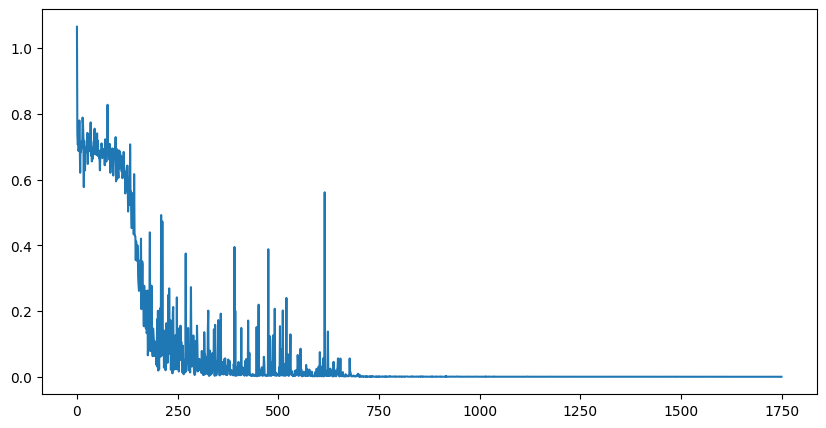

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(loss_hist)

In [7]:
evaluate_model(model, test_loader)
evaluate_model(model, test_loader_positive)
evaluate_model(model, test_loader_negative)
evaluate_model(model, train_loader_positive)
evaluate_model(model, train_loader)

Accuracy: 80.86%
Accuracy: 61.73%
Accuracy: 100.00%
Accuracy: 100.00%
Accuracy: 100.00%


In [8]:
class ProbingClassifier(nn.Module):
    def __init__(self, embed_dim, output_dim):
        super(ProbingClassifier, self).__init__()
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

def simulate_stack(sequence):
    stack = []
    labels = []
    for token in sequence:
        if token == 3: 
            stack.append(1)  
        elif token == 4 and stack: 
            stack.pop()  
        labels.append(stack[-1] if stack else 0)
    return labels

In [9]:
def create_probing_dataset(model, data_loader, device):
    model.eval()
    probing_features = []
    probing_labels = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            _, internal_representations = model(inputs, return_internal=True)  # Shape: (batch_size, seq_len, embed_dim)

            for batch_idx in range(inputs.size(0)):
                sequence = inputs[batch_idx].cpu().numpy()
                hidden_states = internal_representations[batch_idx]  # Shape: (seq_len, embed_dim)
                labels = simulate_stack(sequence)

                probing_features.append(hidden_states[:len(labels)])
                probing_labels.extend(labels)

    probing_features = torch.cat(probing_features)  # Shape: (total_tokens, embed_dim)
    probing_labels = torch.tensor(probing_labels)  # Shape: (total_tokens,)
    return probing_features, probing_labels

In [10]:
def create_control_probing_dataset(model, data_loader, device):
    model.eval()
    probing_features = []
    probing_labels = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            _, internal_representations = model(inputs, return_internal=True)

            for batch_idx in range(inputs.size(0)):
                sequence = inputs[batch_idx].cpu().numpy()
                hidden_states = internal_representations[batch_idx]
                labels = [random.choice([0, 1]) for _ in range(len(sequence))]

                probing_features.append(hidden_states)
                probing_labels.extend(labels)
    
    probing_features = torch.cat(probing_features)
    probing_labels = torch.tensor(probing_labels)
    return probing_features, probing_labels

In [11]:
def train_probing_classifier(probing_features, probing_labels, embed_dim, epochs=10, batch_size=64):
    dataset = torch.utils.data.TensorDataset(probing_features, probing_labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = ProbingClassifier(embed_dim, output_dim=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_probe = []
    accuracy_probe = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        model.train()
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loss_probe.append(loss.item())
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            accuracy_probe.append(correct / total)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}, Accuracy: {correct / total:.2%}")

    return model, loss_probe, accuracy_probe

In [12]:
def evaluate_probing_classifier(probing_model, features, labels):
    probing_model.eval()
    with torch.no_grad():
        outputs = probing_model(features.to(device))
        predictions = torch.argmax(outputs, dim=1)
        accuracy = (predictions == labels.to(device)).sum().item() / labels.size(0)
    print(f"Probing Classifier Accuracy: {accuracy:.2%}")

In [13]:
losses_control_probe = []
accuracy_control_probe = []
probing_features_control, probing_labels_control = create_control_probing_dataset(model, train_loader, device)
probing_model_control, loss_control_probe, accuracy_control_probe = train_probing_classifier(probing_features_control, probing_labels_control, 64, epochs=200)
evaluate_probing_classifier(probing_model_control, probing_features_control, probing_labels_control)

Epoch 1/200, Loss: 0.7018, Accuracy: 49.60%
Epoch 2/200, Loss: 0.6967, Accuracy: 50.14%
Epoch 3/200, Loss: 0.6950, Accuracy: 50.39%
Epoch 4/200, Loss: 0.6946, Accuracy: 50.53%
Epoch 5/200, Loss: 0.6949, Accuracy: 50.88%
Epoch 6/200, Loss: 0.6942, Accuracy: 51.00%
Epoch 7/200, Loss: 0.6940, Accuracy: 51.28%
Epoch 8/200, Loss: 0.6941, Accuracy: 51.10%
Epoch 9/200, Loss: 0.6944, Accuracy: 50.90%
Epoch 10/200, Loss: 0.6937, Accuracy: 51.41%
Epoch 11/200, Loss: 0.6944, Accuracy: 51.01%
Epoch 12/200, Loss: 0.6938, Accuracy: 50.84%
Epoch 13/200, Loss: 0.6939, Accuracy: 51.29%
Epoch 14/200, Loss: 0.6940, Accuracy: 51.00%
Epoch 15/200, Loss: 0.6935, Accuracy: 51.34%
Epoch 16/200, Loss: 0.6942, Accuracy: 51.12%
Epoch 17/200, Loss: 0.6949, Accuracy: 50.72%
Epoch 18/200, Loss: 0.6942, Accuracy: 50.87%
Epoch 19/200, Loss: 0.6939, Accuracy: 50.79%
Epoch 20/200, Loss: 0.6940, Accuracy: 51.13%
Epoch 21/200, Loss: 0.6940, Accuracy: 50.99%
Epoch 22/200, Loss: 0.6942, Accuracy: 50.86%
Epoch 23/200, Loss:

In [14]:
losses_probe = []
accuracy_probe = []
probing_features, probing_labels = create_probing_dataset(model, test_loader, device)
probing_model, losses_probe, accuracy_probe = train_probing_classifier(probing_features, probing_labels, embed_dim=64, epochs=200)
evaluate_probing_classifier(probing_model, probing_features, probing_labels)

Epoch 1/200, Loss: 0.2774, Accuracy: 93.39%
Epoch 2/200, Loss: 0.2256, Accuracy: 94.10%
Epoch 3/200, Loss: 0.2089, Accuracy: 94.29%
Epoch 4/200, Loss: 0.1984, Accuracy: 94.34%
Epoch 5/200, Loss: 0.1917, Accuracy: 94.56%
Epoch 6/200, Loss: 0.1865, Accuracy: 94.71%
Epoch 7/200, Loss: 0.1828, Accuracy: 94.75%
Epoch 8/200, Loss: 0.1796, Accuracy: 94.74%
Epoch 9/200, Loss: 0.1772, Accuracy: 94.75%
Epoch 10/200, Loss: 0.1745, Accuracy: 94.80%
Epoch 11/200, Loss: 0.1724, Accuracy: 94.86%
Epoch 12/200, Loss: 0.1706, Accuracy: 94.88%
Epoch 13/200, Loss: 0.1691, Accuracy: 94.81%
Epoch 14/200, Loss: 0.1679, Accuracy: 94.78%
Epoch 15/200, Loss: 0.1663, Accuracy: 94.80%
Epoch 16/200, Loss: 0.1649, Accuracy: 94.79%
Epoch 17/200, Loss: 0.1640, Accuracy: 94.82%
Epoch 18/200, Loss: 0.1631, Accuracy: 94.86%
Epoch 19/200, Loss: 0.1620, Accuracy: 94.84%
Epoch 20/200, Loss: 0.1611, Accuracy: 94.81%
Epoch 21/200, Loss: 0.1604, Accuracy: 94.84%
Epoch 22/200, Loss: 0.1594, Accuracy: 94.81%
Epoch 23/200, Loss:

In [15]:
untrained_model = SmallTransformer().to(device)

/Users/utkarsh/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
untrained_probing_features, untrained_probing_labels = create_probing_dataset(
    untrained_model, test_loader, device
)

untrained_losses_probe = []
untrained_accuracy_probe = []
untrained_probing_model, untrained_losses_probe, untrained_accuracy_probe = train_probing_classifier(
    untrained_probing_features, untrained_probing_labels, embed_dim=64, epochs=200
)

print("Probing classifier results for untrained model:")
evaluate_probing_classifier(untrained_probing_model, untrained_probing_features, untrained_probing_labels)



# Compare with trained model
print("Probing classifier results for trained model:")
evaluate_probing_classifier(probing_model, probing_features, probing_labels)

Epoch 1/200, Loss: 0.4264, Accuracy: 75.60%
Epoch 2/200, Loss: 0.3853, Accuracy: 78.48%
Epoch 3/200, Loss: 0.3761, Accuracy: 79.24%
Epoch 4/200, Loss: 0.3709, Accuracy: 79.54%
Epoch 5/200, Loss: 0.3677, Accuracy: 80.01%
Epoch 6/200, Loss: 0.3642, Accuracy: 80.20%
Epoch 7/200, Loss: 0.3616, Accuracy: 80.56%
Epoch 8/200, Loss: 0.3602, Accuracy: 80.59%
Epoch 9/200, Loss: 0.3581, Accuracy: 80.51%
Epoch 10/200, Loss: 0.3558, Accuracy: 81.04%
Epoch 11/200, Loss: 0.3545, Accuracy: 81.20%
Epoch 12/200, Loss: 0.3528, Accuracy: 81.20%
Epoch 13/200, Loss: 0.3515, Accuracy: 81.39%
Epoch 14/200, Loss: 0.3503, Accuracy: 81.54%
Epoch 15/200, Loss: 0.3489, Accuracy: 81.71%
Epoch 16/200, Loss: 0.3472, Accuracy: 81.89%
Epoch 17/200, Loss: 0.3466, Accuracy: 81.96%
Epoch 18/200, Loss: 0.3451, Accuracy: 82.21%
Epoch 19/200, Loss: 0.3440, Accuracy: 82.23%
Epoch 20/200, Loss: 0.3428, Accuracy: 82.49%
Epoch 21/200, Loss: 0.3416, Accuracy: 82.67%
Epoch 22/200, Loss: 0.3401, Accuracy: 82.64%
Epoch 23/200, Loss:

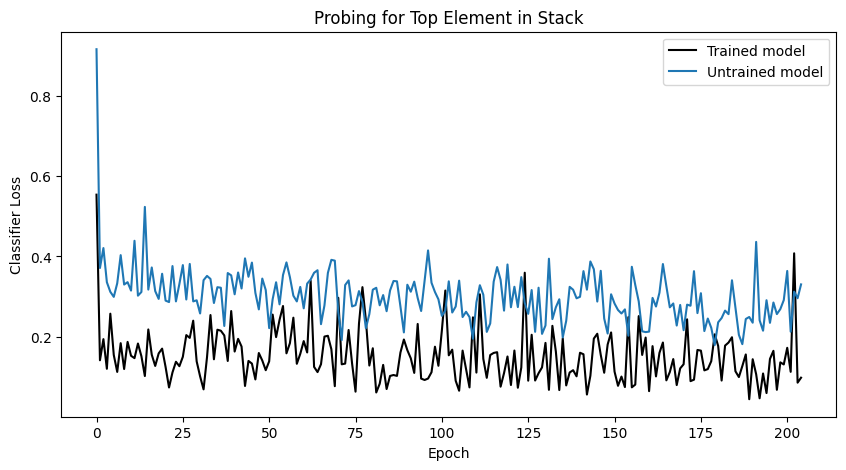

In [17]:
plt.figure(figsize=(10, 5))

plt.plot(losses_probe[::500], label="Trained model", color='black')
plt.plot(untrained_losses_probe[::500], label="Untrained model")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Classifier Loss")
plt.title("Probing for Top Element in Stack")
plt.show()

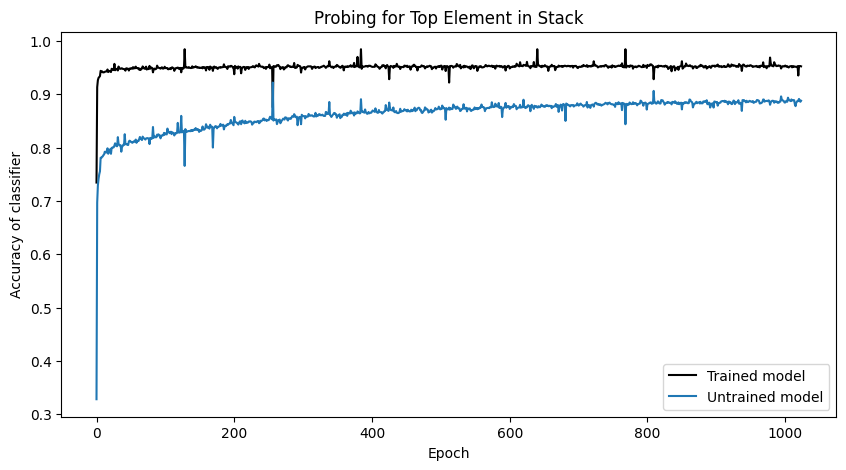

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy_probe[::100], label="Trained model", color='black')
plt.plot(untrained_accuracy_probe[::100], label="Untrained model")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy of classifier")
plt.title("Probing for Top Element in Stack")
plt.show()

In [19]:
print(len(accuracy_control_probe))
len(accuracy_probe)

63200


102400

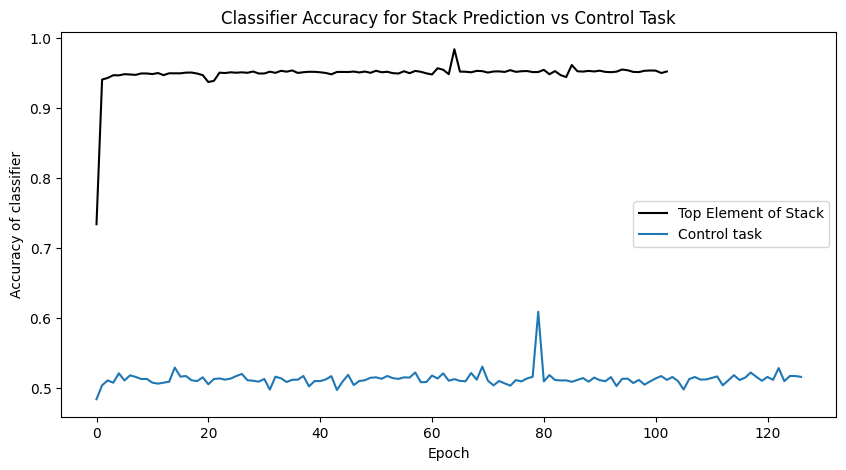

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy_probe[::1000], label="Top Element of Stack", color='black')
plt.plot(accuracy_control_probe[::500], label="Control task")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy of classifier")
plt.title("Classifier Accuracy for Stack Prediction vs Control Task")
plt.show()

In [37]:
class ProbingClassifier_ablation(nn.Module):
    def __init__(self, embed_dim, output_dim, n_layers):
        super(ProbingClassifier_ablation, self).__init__()
        layers = []
        for _ in range(n_layers):
            layers.append(nn.Linear(embed_dim, embed_dim))
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.layers(x)
        return self.fc(x)

In [38]:
def train_probing_classifier_ablation(probing_features, probing_labels, embed_dim, n_layers, epochs=10, batch_size=64):
    dataset = torch.utils.data.TensorDataset(probing_features, probing_labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Instantiate the probing classifier with given `n_layers`
    model = ProbingClassifier_ablation(embed_dim=embed_dim, output_dim=2, n_layers=n_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_probe = []
    accuracy_probe = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        model.train()
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        loss_probe.append(total_loss / len(data_loader))
        accuracy_probe.append(correct / total)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}, Accuracy: {correct / total:.2%}")

    return model, loss_probe, accuracy_probe

In [46]:
n_layers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
stack_accuracies = []
control_accuracies = []
selectivities = []

for n_layer in n_layers:
    print(f"\nTraining Probing Classifier with Number of Layers: {n_layer}")

    # Create probing datasets for stack and control tasks
    probing_features_stack, probing_labels_stack = create_probing_dataset(model, train_loader, device)
    probing_features_control, probing_labels_control = create_control_probing_dataset(model, train_loader, device)

    # Train probing classifier for stack task
    stack_classifier, _,  stack_accuracy = train_probing_classifier_ablation(
        probing_features_stack, probing_labels_stack, embed_dim=64, n_layers=n_layer, epochs=100
    )
    evaluate_probing_classifier(stack_classifier, probing_features_stack, probing_labels_stack)
    stack_accuracies.append(stack_accuracy[-1])

    # Train probing classifier for control task
    control_classifier, _, control_accuracy = train_probing_classifier_ablation(
        probing_features_control, probing_labels_control, embed_dim=64, n_layers=n_layer, epochs=100
    )
    evaluate_probing_classifier(control_classifier, probing_features_control, probing_labels_control)
    control_accuracies.append(control_accuracy[-1])

    # Calculate selectivity
    for i in range(len(stack_accuracies)):
        selectivities.append(stack_accuracies[i] - control_accuracies[i])



Training Probing Classifier with Number of Layers: 1
Epoch 1/100, Loss: 0.2614, Accuracy: 90.68%
Epoch 2/100, Loss: 0.1877, Accuracy: 92.87%
Epoch 3/100, Loss: 0.1717, Accuracy: 93.24%
Epoch 4/100, Loss: 0.1656, Accuracy: 93.38%
Epoch 5/100, Loss: 0.1618, Accuracy: 93.37%
Epoch 6/100, Loss: 0.1569, Accuracy: 93.48%
Epoch 7/100, Loss: 0.1551, Accuracy: 93.60%
Epoch 8/100, Loss: 0.1530, Accuracy: 93.59%
Epoch 9/100, Loss: 0.1485, Accuracy: 93.65%
Epoch 10/100, Loss: 0.1477, Accuracy: 93.72%
Epoch 11/100, Loss: 0.1452, Accuracy: 93.77%
Epoch 12/100, Loss: 0.1428, Accuracy: 93.88%
Epoch 13/100, Loss: 0.1398, Accuracy: 94.01%
Epoch 14/100, Loss: 0.1408, Accuracy: 93.88%
Epoch 15/100, Loss: 0.1392, Accuracy: 93.97%
Epoch 16/100, Loss: 0.1361, Accuracy: 93.96%
Epoch 17/100, Loss: 0.1359, Accuracy: 94.15%
Epoch 18/100, Loss: 0.1356, Accuracy: 94.11%
Epoch 19/100, Loss: 0.1321, Accuracy: 94.20%
Epoch 20/100, Loss: 0.1300, Accuracy: 94.34%
Epoch 21/100, Loss: 0.1284, Accuracy: 94.30%
Epoch 22/1

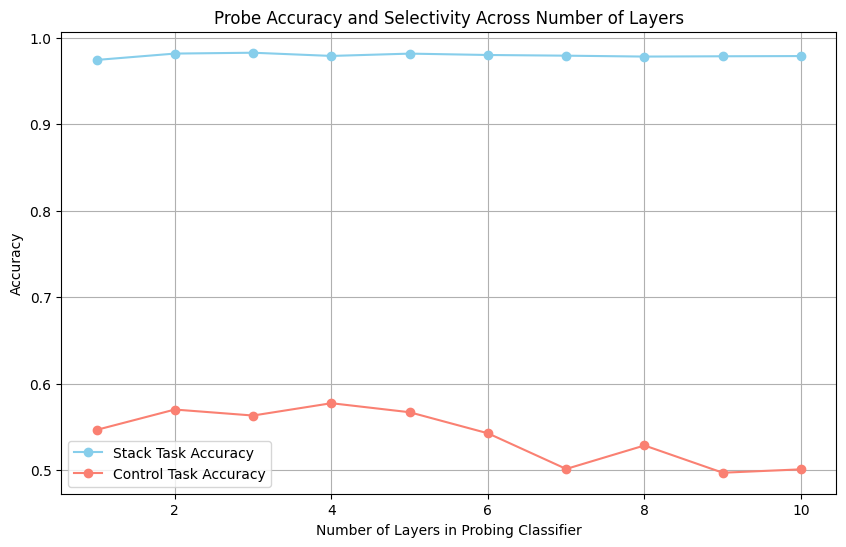

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(n_layers, stack_accuracies, label="Stack Task Accuracy", marker="o", color="skyblue")
plt.plot(n_layers, control_accuracies, label="Control Task Accuracy", marker="o", color="salmon")
# plt.bar([str(layer) for layer in n_layers], selectivities, alpha=0.3, label="Selectivity", color="blue", width=0.4)

plt.xlabel("Number of Layers in Probing Classifier")
plt.ylabel("Accuracy")
plt.title("Probe Accuracy and Selectivity Across Number of Layers")
plt.legend()
plt.grid()
plt.show()